# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using Estimator. 

Note the MODEL_TYPE; change it to try out different models

In [22]:
import os
import tensorflow as tf
PROJECT = "qwiklabs-gcp-636667ae83e902b6"  # Replace with your PROJECT
BUCKET =  "qwiklabs-gcp-636667ae83e902b6_al"  # Replace with your BUCKET
REGION = "us-east1"            # Choose an available region for AI Platform  
MODEL_TYPE = "cnn"  # "linear", "dnn", "dnn_dropout", or "cnn"

# do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "1.13"  # Tensorflow version

In [23]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Run as a Python module

In the previous notebook (mnist_linear.ipynb) we ran our code directly from the notebook.

Now since we want to run our code on Cloud ML Engine, we've packaged it as a python module.

The `model.py` and `task.py` containing the model code is in <a href="mnistmodel/trainer">mnistmodel/trainer</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set MODEL_TYPE and run it locally for a few steps to test the code.

In [24]:
%%bash
rm -rf mnistmodel.tar.gz mnist_trained
gcloud ai-platform local train \
    --module-name=trainer.task \
    --package-path=${PWD}/mnistmodel/trainer \
    -- \
    --output_dir=${PWD}/mnist_trained \
    --train_steps=100 \
    --learning_rate=0.01 \
    --model=$MODEL_TYPE

W0725 15:06:01.784848 139974355895744 deprecation_wrapper.py:119] From trainer/model.py:23: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0725 15:06:01.785161 139974355895744 deprecation_wrapper.py:119] From trainer/model.py:23: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0725 15:06:01.786645 139974355895744 deprecation_wrapper.py:119] From trainer/model.py:110: The name tf.summary.FileWriterCache is deprecated. Please use tf.compat.v1.summary.FileWriterCache instead.

W0725 15:06:02.620280 139974355895744 deprecation_wrapper.py:119] From trainer/model.py:130: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

W0725 15:06:02.620625 139974355895744 deprecation_wrapper.py:119] From trainer/model.py:130: The name tf.estimator.inputs.numpy_input_fn is deprecated. Please use tf.compat.v1.estimator.inputs.numpy_input_fn instead.

W0725 15:06:02.6

**Now, let's do it on Cloud ML Engine so we can train on GPU:** `--scale-tier=BASIC_GPU`

Note the GPU speed up depends on the model type. You'll notice the more complex CNN model trains significantly faster on GPU, however the speed up on the simpler models is not as pronounced.

In [33]:
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file

In [34]:
%%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=trainer.task \
    --package-path=${PWD}/mnistmodel/trainer \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --train_steps=10000 --learning_rate=0.01 --train_batch_size=512 \
    --model=$MODEL_TYPE --batch_norm

gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn us-east1 mnist_cnn_190725_152407
jobId: mnist_cnn_190725_152407
state: QUEUED


Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/checkpoint#1564066643012451...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/eval/#1564066564606604...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/#1564066641836037...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/eval/events.out.tfevents.1564066564.cmle-training-16404510780514480312#1564066645893363...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/events.out.tfevents.1564066491.cmle-training-16404510780514480312#1564066650642132...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/export/#1564066566112540...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/export/exporter/1564066565/variables/variables.data-00000-of-00001#1564066569956951...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/export/exporter/1564066645/saved_model.pb#1564066649888256...
Removing gs://qwiklabs-gcp-636667ae83e902b6_al/m

## Monitoring training with TensorBoard

Use this cell to launch tensorboard

In [35]:
OUTDIR="gs://{}/mnist/trained_{}".format(BUCKET, MODEL_TYPE)

In [36]:
get_ipython().system_raw(
    "tensorboard --logdir gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn --host 0.0.0.0 --port 6006 &"
)

get_ipython().system_raw("/home/jupyter/training-data-analyst/courses/machine_learning/asl/02_tensorflow/assets/ngrok http 6006 &")

In [37]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ec6f12e8.ngrok.io


Here are my results:

Model | Accuracy | Time taken | Model description | Run time parameters
--- | :---: | ---
linear | 91.53 | 3 min | linear | 100 steps, LR=0.01, Batch=512
linear | 92.73 | 8 min | linear | 1000 steps, LR=0.01, Batch=512
linear | 92.29 | 18 min | linear | 10000 steps, LR=0.01, Batch=512
dnn | 98.14 | 15 min | 300-100-30 nodes fully connected | 10000 steps, LR=0.01, Batch=512
dnn | 97.99 | 48 min | 300-100-30 nodes fully connected | 100000 steps, LR=0.01, Batch=512
dnn_dropout | 97.84 | 29 min | 300-100-30-DL(0.1)- nodes | 20000 steps, LR=0.01, Batch=512
cnn | 98.97 | 35 min | maxpool(10 5x5 cnn, 2)-maxpool(20 5x5 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 98.93 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 99.17 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits only) | 20000 steps, LR=0.01, Batch=512
cnn | 99.27 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits, deep) | 10000 steps, LR=0.01, Batch=512
cnn | 99.48 | 12 hr | as-above but nfil1=20, nfil2=27, dprob=0.1, lr=0.001, batchsize=233 | (hyperparameter optimization)

Create a table to keep track of your own results as you experiment with model type and hyperparameters!

## Deploying and predicting with model

Deploy the model:

In [38]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained_${MODEL_TYPE}/export/exporter | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

Deleting and deploying mnist cnn from gs://qwiklabs-gcp-636667ae83e902b6_al/mnist/trained_cnn/export/exporter/1564068637/ ... this will take a few minutes


Created ml engine model [projects/qwiklabs-gcp-636667ae83e902b6/models/mnist].
Creating version (this might take a few minutes)......
.......................................................................................................................................................................................................................................................................................................................................................................................done.


To predict with the model, let's take one of the example images.

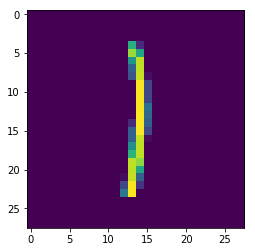

In [47]:
import json, codecs
import matplotlib.pyplot as plt
import tensorflow as tf

HEIGHT = 28
WIDTH = 28

# Get mnist data
mnist = tf.keras.datasets.mnist

(_, _), (x_test, _) = mnist.load_data()

# Scale our features between 0 and 1
x_test = x_test / 255.0 

IMGNO = 40 # CHANGE THIS to get different images
jsondata = {"image": x_test[IMGNO].reshape(HEIGHT, WIDTH).tolist()}
json.dump(jsondata, codecs.open("test.json", 'w', encoding = "utf-8"))
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [48]:
%%bash
gcloud ai-platform predict \
   --model=mnist \
   --version=${MODEL_TYPE} \
   --json-instances=./test.json

PROBABILITIES
[1.1342117289814269e-07, 0.999981164932251, 8.340186319344411e-09, 7.945415880783457e-09, 6.566759136461542e-09, 3.7124738128113677e-07, 1.2292305839878281e-08, 3.865041975359418e-08, 1.817613338062074e-05, 1.3766094753009384e-07]


<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>